In [2]:
%matplotlib notebook
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import os
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from nltk import word_tokenize

In [3]:
sns.set(style="darkgrid")

In [4]:
filename = "Data/lexicons/druglexiconrevised.json"
file = open(filename, encoding="utf-8")
drugs=json.load(file)
file.close()

In [5]:
filename = "Data/lexicons/bodypartlexicon.json"
file = open(filename, encoding="utf-8")
parts=json.load(file)

In [6]:
filename = "Data/lexicons/roalexicon.json"
file = open(filename, encoding="utf-8")
roas=json.load(file)

In [7]:
op_od = pd.DataFrame()
op_od["all opioids"] =[2907,3223,3523,3435,3285,3217,3443,3400,3349,3511,3568,3846]
op_od["other synthetic opioids (fentanyl, tramadol)"] = [1036,1377,1528,1538, 1542,1458,1601,1576,1711,1885,1983,2155]
op_od["other synthetic opioids and cocaine"]=[178,262,290,325,293,292,352,372,412,449,462,495]

In [8]:
dop_od = op_od[1:].reset_index(drop=True) - op_od[:-1].reset_index(drop=True)
dop_od.index = pd.date_range(start="1/1/2016", periods=11, freq="MS")
op_od.index = pd.date_range(start="1/1/2016", periods=12, freq="MS")

In [9]:
dates = pd.date_range(start="1/1/2016", periods=15, freq="MS")

In [10]:
def create_tokens():
    tokenList = []
    for body in df["body"]:
        tokens = word_tokenize(body.lower())
        tokenList.append(tokens)
    return tokenList

In [11]:
frames = []
for i in range(9):
    newf = pd.read_json("Data/2016/opcomments2016-0" + str(1+i), encoding="utf-8")
    newf["date"]= [dates[i] for row in newf.iterrows()]
    frames.append(newf)
for i in range(3):
    newf = pd.read_json("Data/2016/opcomments2016-" + str(10+i), encoding="utf-8")
    newf["date"]= [dates[9+i] for row in newf.iterrows()]
    frames.append(newf)
for i in range(3):
    newf = pd.read_json("Data/2017/opcomments2017-0" + str(1+i), encoding="utf-8")
    newf["date"]= [dates[12+i] for row in newf.iterrows()]
    frames.append(newf)
df = pd.concat(frames)
df["tokens"] = create_tokens()

In [12]:
opl = []
for date in dates:
    opl.append(df[df["date"] == date].shape[0])

In [13]:
def word_freq(func):
    result = {}
    for index, row in df.iterrows():
        for token in row["tokens"]:
            if token in result:
                result[token]+=1
            else:
                result[token] = 1
    for key in result:
        result[key] = func(result[key])
    return result


In [14]:
idf=word_freq(lambda x: 1/(1+np.log(x)))

In [15]:
def mentions_roas(tokens):
    result = []
    for roa in roas:
        contains = False
        for term in roas[roa]:
            if term in tokens:
                contains = True
        if contains:
            result.append(roa)
    return result

In [16]:
def mentions_parts(tokens):
    result = []
    for part in parts:
        contains = False
        for term in parts[part]:
            if term in tokens:
                contains = True
        if contains:
            result.append(part)
    return result

In [17]:
def mentions_drug(drug, tokens):
    return [term for term in drugs[drug] if (term in tokens)]

In [18]:
def remove_slang(term):
    for drug in drugs:
        if term in drugs[drug]:
            drugs[drug].remove(term)

In [19]:
for drug in drugs:
    df[drug] = [mentions_drug(drug, tokens) for tokens in df["tokens"]]
df["parts"] = [mentions_parts(tokens) for tokens in df["tokens"]]
df["roas"] = [mentions_roas(tokens) for tokens in df["tokens"]]

In [20]:
slangVector = []
for index, row in df.iterrows():
    slang = []
    for drug in drugs:
        slang.extend(row[drug])
    slangVector.append(slang)
df["all slang"]=slangVector

In [21]:
dfs = [df[df["date"] == date] for date in dates]
#for a in dfs:
#    print(a.shape)
#print(df.shape)

In [22]:
ac = []
fc = []
dc = []
ad = []
fd = []
fa = []
for a in dfs:
    acdf=a[[(len(row['fentanyl']) > 0)for index,row in a.iterrows()]]
    fcdf=a[[(len(row['fentanyl']) > 0) & (len(row['cocaine']) > 0) for index,row in a.iterrows()]]
    ac.append(acdf.shape[0])
    fc.append(fcdf.shape[0])
    dc.append(a.shape[0])
    ad.append(acdf.shape[0]/a.shape[0])
    fd.append(fcdf.shape[0]/a.shape[0])
    fa.append(fcdf.shape[0]/acdf.shape[0])


In [23]:
ndf = pd.DataFrame([ad,fd,fa, ac, fc, dc]).T
ndf.index = dates
ndf.columns = ["Fentanyl vs Opiates","Fentanyl and Cocaine vs Opiates","Fentanyl and Cocaine vs Fentanyl", "Fentanyl", "Fentanyl and Cocaine", "Opiates"]
ndf = pd.concat([ndf,op_od], axis=1)
ndf

,Fentanyl vs Opiates,Fentanyl and Cocaine vs Opiates,Fentanyl and Cocaine vs Fentanyl,Fentanyl,Fentanyl and Cocaine,Opiates,all opioids,"other synthetic opioids (fentanyl, tramadol)",other synthetic opioids and cocaine
2016-01-01,0.135512,0.005570,0.041107,1265.0,52.0,9335.0,2907.0,1036.0,178.0
2016-02-01,0.178005,0.007501,0.042136,1685.0,71.0,9466.0,3223.0,1377.0,262.0
2016-03-01,0.157293,0.005865,0.037286,1636.0,61.0,10401.0,3523.0,1528.0,290.0
2016-04-01,0.210833,0.009688,0.045953,1915.0,88.0,9083.0,3435.0,1538.0,325.0
2016-05-01,0.186471,0.007583,0.040663,1869.0,76.0,10023.0,3285.0,1542.0,293.0
2016-06-01,0.252066,0.009936,0.039419,2410.0,95.0,9561.0,3217.0,1458.0,292.0
2016-07-01,0.205439,0.009611,0.046784,1881.0,88.0,9156.0,3443.0,1601.0,352.0
2016-08-01,0.252824,0.012260,0.048493,2887.0,140.0,11419.0,3400.0,1576.0,372.0
2016-09-01,0.338741,0.016223,0.047892,4719.0,226.0,13931.0,3349.0,1711.0,412.0
2016-10-01,0.283896,0.014000,0.049313,3346.0,165.0,11786.0,3511.0,1885.0,449.0


<IPython.core.display.Javascript object>


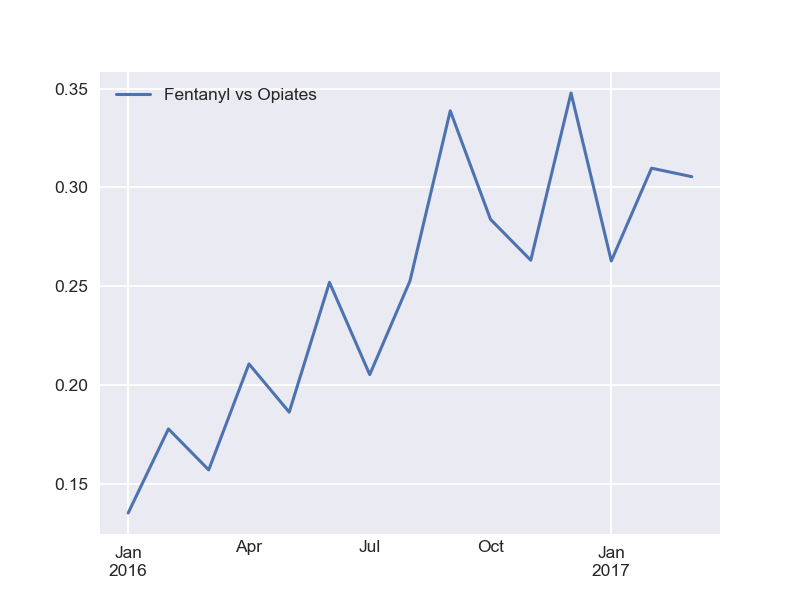

In [31]:
plt.figure()
ndf[ndf.columns[0]].plot()
plt.legend(loc='best')

<IPython.core.display.Javascript object>


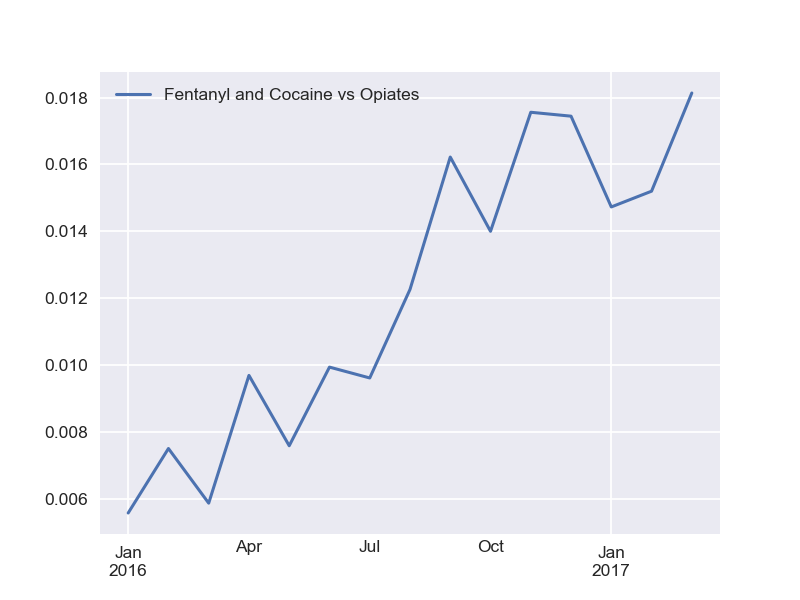

In [56]:
plt.figure()
ndf[ndf.columns[1]].plot()
plt.legend(loc='best')

<IPython.core.display.Javascript object>


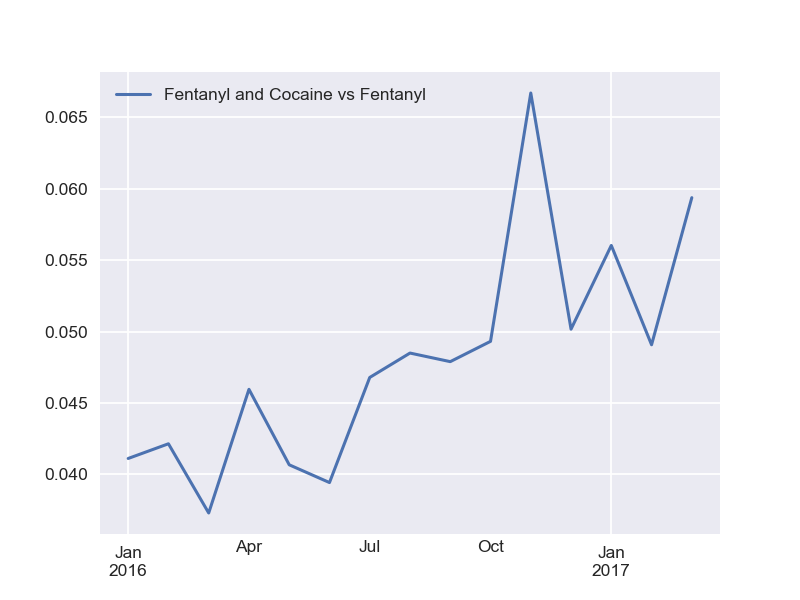

In [32]:
plt.figure()
ndf[ndf.columns[2]].plot()
plt.legend(loc='best')

<IPython.core.display.Javascript object>


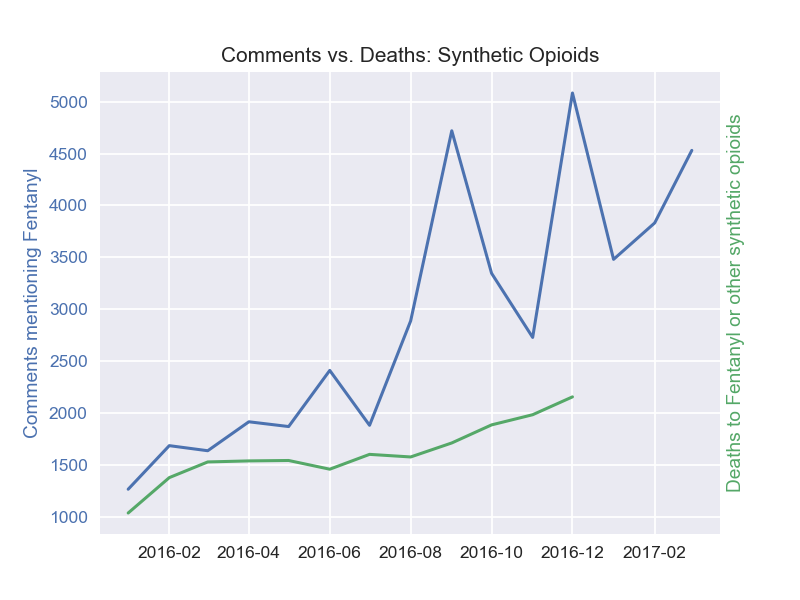

Text(0.5,1,'Comments vs. Deaths: Synthetic Opioids')

In [132]:
fig=plt.figure()


ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(dates, ndf[ndf.columns[3]], color="C0")
ax.set_ylabel("Comments mentioning Fentanyl", color="C0")
ax.tick_params(axis='y', colors="C0")



ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_ylabel('Deaths to Fentanyl or other synthetic opioids', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")
ax.plot(dates, ndf[ndf.columns[7]], color="C1")
plt.title("Comments vs. Deaths: Synthetic Opioids")

<IPython.core.display.Javascript object>


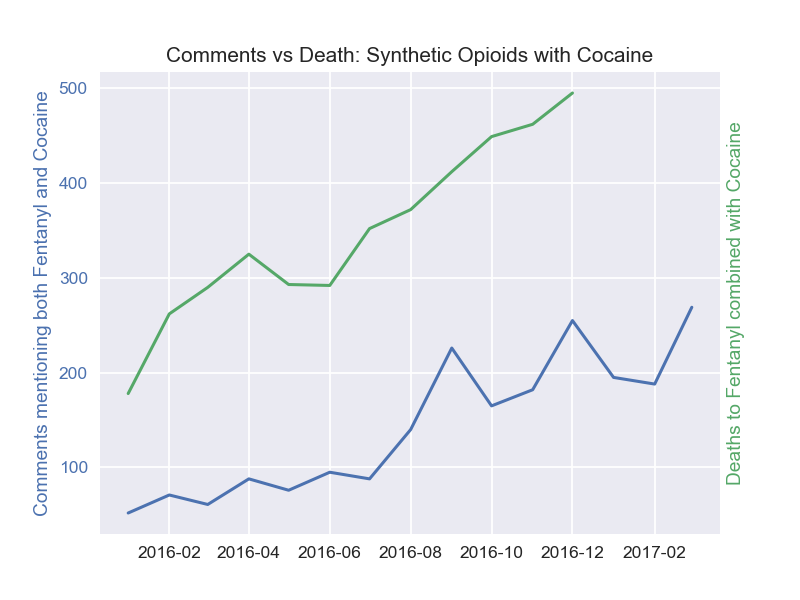

Text(0.5,1,'Comments vs Death: Synthetic Opioids with Cocaine')

In [133]:
fig=plt.figure()

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(dates, ndf[ndf.columns[4]], color="C0")
ax.set_ylabel("Comments mentioning both Fentanyl and Cocaine", color="C0")
ax.tick_params(axis='y', colors="C0")



ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_ylabel('Deaths to Fentanyl combined with Cocaine', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")
ax.plot(dates, ndf[ndf.columns[8]], color="C1")
plt.title("Comments vs Death: Synthetic Opioids with Cocaine")

<IPython.core.display.Javascript object>


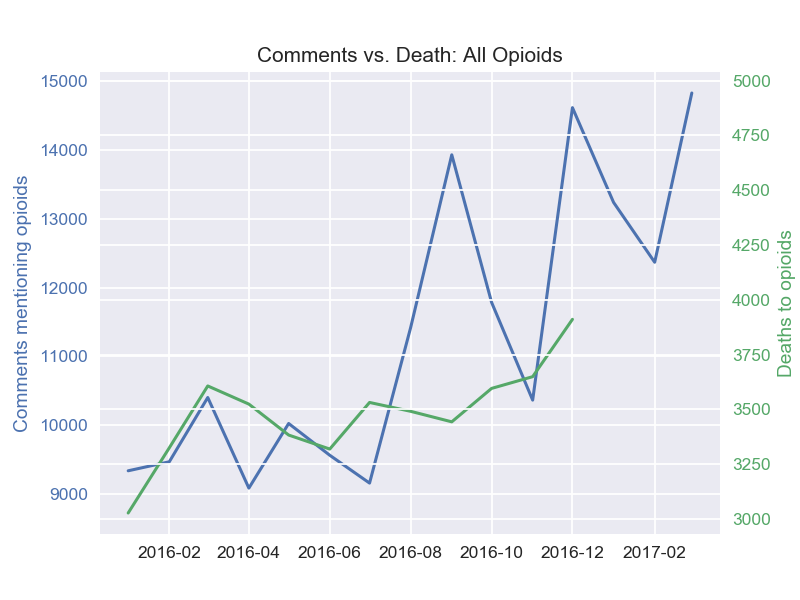

Text(0.5,1,'Comments vs. Death: All Opioids')

In [134]:
fig=plt.figure()

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(dates, ndf[ndf.columns[5]], color="C0")
ax.set_ylabel("Comments mentioning opioids", color="C0")
ax.tick_params(axis='y', colors="C0")


ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.xaxis.set_major_locator(plt.NullLocator())
y1, y2= ax.get_ylim()
ax2.set_ylim([y1/3, y2/3])
ax2.set_ylabel('Deaths to opioids', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")
ax.plot(dates, ndf[ndf.columns[6]]*3, color="C1")
plt.title("Comments vs. Death: All Opioids")

In [30]:
ndf[comments]

NameError: name 'comments' is not defined

In [ ]:
# arbitrary increase in importance of the drugs we are looking at.
idfplus = idf.copy()
for drug in drugs:
    if drug in idfplus:
        idfplus[drug] += .1

In [ ]:
dbonus = .1
def cos_sim(row1, row2):
    tokens1 = row1["tokens"]
    tokens2 = row2["tokens"]
    norm1 = 0.
    norm2 = 0.
    iproduct = 0.
    for token in tokens1:
        value = idf[token]
        if token in tokens2:
            iproduct += idf[token]**2
        norm1 += idf[token]**2
    for token in tokens2:
        norm2 += idf[token]**2
    for drug in drugs:
        if len(row1[drug]) > 0:
            norm1 += dbonus**2
            if len(row2[drug]) > 0:
                iproduct += dbonus**2 / 2
                for term in row1[drug]:
                    if term in row2[drug]:
                        iproduct += dbonus**2 / 2
                        break
    for drug in drugs:
        if len(row2[drug]) > 0:
            norm2 += dbonus**2
    return iproduct/np.sqrt(norm1 * norm2)

In [ ]:
df.size

In [ ]:
df["all slang"].head(10)

In [ ]:
df["simtotwo"] = [cos_sim(df.iloc[2,:], row) for index, row in df.iterrows()]

In [ ]:
dfsort = df.sort_values(by=["simtozero"], ascending=False)
dfsort1 = df.sort_values(by=["simtoone"], ascending=False)
dfsort2 = df.sort_values(by=["simtotwo"], ascending=False)

In [ ]:
for i in range(20):
    print(df.body.iloc[i] + "\n")

In [ ]:
dfsort.body.iloc[1]

In [ ]:
df.body[1]

In [ ]:
#params
drug_weight = 10.
part_weight = 1.
roa_weight = 20.
word_weight = 1.
subreddit_weight = 0.

In [ ]:
def vectorize(row):
    vector = []
    for drug in drugs:
        if len(row[drug])>0:
            vector.append(drug_weight)
        else:
            vector.append(0.)
    for roa in roas:
        if roa in row["roas"]:
            vector.append(roa_weight)
        else:
            vector.append(0.)
    for part in parts:
        if part in row["parts"]:
            vector.append(part_weight)
        else:
            vector.append(0.)
    vector.extend(word_vector(row))
    vector.extend(subreddit_vector(row))
    return vector

In [ ]:
#not implemented
def word_vector(row):
    result = []
    n = len(row["tokens"])
    for key in idf:
        if key in row["tokens"]:
            result.append(word_weight * idf[key])
        else:
            result.append(0.)
    return result

In [ ]:
#not implemented
def subreddit_vector(row):
    return [0.]

In [ ]:
rows = df.iterrows()
index, row = next(rows)
len(vectorize(row))

In [ ]:
vectored = [vectorize(row) for index, row in df.iterrows()]

In [ ]:
X = np.array(vectored)
kmeans = KMeans(n_clusters=100,random_state=0).fit(X)
dfk = df[kmeans.labels_ == 0]

In [ ]:
df.iloc[4]

In [ ]:
df7=df[df["date"]==dates[6]]
df9=df[df["date"]==dates[8]]
df11=df[df["date"]==dates[10]]

In [ ]:
df7f = df7[[len(row["fentanyl"]) > 0 for index,row in df7.iterrows()]]
df9f = df9[[len(row["fentanyl"]) > 0 for index,row in df9.iterrows()]]
df11f = df11[[len(row["fentanyl"]) > 0 for index,row in df11.iterrows()]]

In [ ]:
df7f = df7f.reset_index(drop=True)
df9f = df9f.reset_index(drop=True)
df11f = df11f.reset_index(drop=True)

In [ ]:
df7f.body[1]

In [128]:
pop_posts = df.groupby(["link_id", "date"]).size().sort_values(ascending=False)[:5]
datesg = []
for i in range(len(pop_posts)):
    datesg.append(str(pop_posts.index[i][1].month) + "/"+ str(pop_posts.index[i][1].year) + "\n" + str(pop_posts.index[i][0]))
datesg

['9/2016\nt3_557vlt',
 '12/2016\nt3_5l3dsr',
 '12/2016\nt3_5hq6ya',
 '5/2016\nt3_4iw37c',
 '10/2016\nt3_59u5yq']

In [135]:
fig=plt.figure()
plt.title("Posts with most opioid related comments")
y_pos = np.arange(5)
plt.bar(y_pos, pop_posts, align='center')
plt.xticks(y_pos, datesg)

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x1cfdc2cbb70>,
 <a list of 5 Text xticklabel objects>)